# Raw: Initial Codes

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class Life_6:
    def __init__(self, investment_fraction, interest_rate_proc=5, income=10000, spending=7000, tax_rate=0.19,
                 pension=4000, starting_age=18, retirement_age=67, pay_raise=250, life_inflation=50, inflation_proc=4):
        self.investment_fraction = investment_fraction  # beta
        self.interest_rate_proc = interest_rate_proc  # 5%
        self.income = income  # gold pcs. per month
        self.spending = spending  # gold pcs. per month
        self.tax_rate = tax_rate  # example
        self.pension = pension
        self.starting_age = starting_age
        self.retirement_age = retirement_age
        self.pay_raise = pay_raise
        self.life_inflation = life_inflation
        self.inflation_proc = inflation_proc

    def earn(self, t):
        if t < self.starting_age:
            return 0
        elif self.starting_age <= t < self.retirement_age:
            return 12 * (self.income + self.pay_raise \
                      * (t - self.starting_age))
        else:
            return 12 * self.pension

    def spend(self, t):
        return 12 * (self.spending + self.life_inflation \
                  * (t - self.starting_age))

    def pay_taxes(self, t):
        return self.earn(t) * self.tax_rate

def live_with_investing(x, t, you):
    balance = you.earn(t) - you.spend(t) - you.pay_taxes(t)
    x1 = balance * (1 - you.investment_fraction) - np.log(1 + 0.01 * you.inflation_proc) * x[0]
    if t < you.retirement_age:
        x2 = np.log(1 + 0.01 * you.interest_rate_proc) * x[1] + you.investment_fraction * balance
    else:
        x2 = np.log(1 + 0.01 * you.interest_rate_proc) * x[1]  # Continue to grow the investment bucket
    x2 -= np.log(1 + 0.01 * you.inflation_proc) * x[1]

    return [x1, x2]

# +
def live_without_investing(x, t, you):
    balance = you.earn(t) - you.spend(t) - you.pay_taxes(t)
    return balance - np.log(1 + 0.01*you.inflation_proc) * x


def simulate(you):
    ...  # t0, t1, t2 - as before
    t0 = np.linspace(0, you.starting_age - 1, num=you.starting_age)
    t1 = np.linspace(you.starting_age, you.retirement_age - 1, num=(you.retirement_age - you.starting_age))
    t2 = np.linspace(you.retirement_age, 100, num=(100 - you.retirement_age))

    # non-investor
    x1_0 = np.zeros((t0.shape[0], 1))
    x1_1 = odeint(live_without_investing, 0, t1, args=(you,))
    x1_2 = odeint(live_without_investing, x1_1[-1], t2, args=(you,))

    # investor
    x2_0 = np.zeros((t0.shape[0], 2))
    x2_1 = odeint(live_with_investing, [0, 0], t1, args=(you,))
    x2_2 = odeint(live_with_investing, x2_1[-1], t2, args=(you,))


    df0 = pd.DataFrame({'time': t0, 'wallet (non-investor)': x1_0[:, 0], 'wallet (investor)': x2_0[:, 0], 'investment bucket (investor)': x2_0[:, 1]})
    df1 = pd.DataFrame({'time': t1, 'wallet (non-investor)': x1_1[:, 0], 'wallet (investor)': x2_1[:, 0], 'investment bucket (investor)': x2_1[:, 1]})
    df2 = pd.DataFrame({'time': t2, 'wallet (non-investor)': x1_2[:, 0], 'wallet (investor)': x2_2[:, 0], 'investment bucket (investor)': x2_2[:, 1]})
    return pd.concat([df0, df1, df2])

In [2]:
import time

start_time = time.time()


betas = [0.001*x for x in range(1000)]
# betas = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
instances = [Life_6(investment_fraction=beta, interest_rate_proc=5, pension=1000) for beta in betas]


dfs = {}
for instance in instances:
    tmp = simulate(instance)
    tmp['total net asssets (investor)'] = tmp['wallet (investor)'] + tmp['investment bucket (investor)']
    tmp = tmp.drop(columns=['wallet (non-investor)', 'wallet (investor)', 'investment bucket (investor)'])
    dfs[instance.investment_fraction] = tmp

end_time = time.time()


print(end_time - start_time, "s")


12.042726039886475 s


# Python Optimization
- Changing Data Structures: Replace the methods of a Python class with functions, and replace attributes with function variables, no longer using the class.
- Reduce function call overheads: Reduce the number of calls to other functions within a function, and rewrite the function to integrate and optimize.
- Replace global variables with local ones (TBC)
- Loop optimization (TBC)

#### Data Structure Modify

In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def earn(t, starting_age, retirement_age, income, pay_raise, pension):
    if t < starting_age:
        return 0
    elif starting_age <= t < retirement_age:
        return 12 * (income + pay_raise * (t - starting_age))
    else:
        return 12 * pension

def spend(t, starting_age, spending, life_inflation):
    return 12 * (spending + life_inflation * (t - starting_age))

def pay_taxes(t, tax_rate, starting_age, retirement_age, income, pay_raise, pension):
    earned = earn(t, starting_age, retirement_age, income, pay_raise, pension)
    return earned * tax_rate

def live_with_investing(x, t, investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):
    balance = earn(t, starting_age, retirement_age, income, pay_raise, pension) - spend(t, starting_age, spending, life_inflation) - pay_taxes(t, tax_rate, starting_age, retirement_age, income, pay_raise, pension)
    x1 = balance * (1 - investment_fraction) - np.log(1 + 0.01 * inflation_proc) * x[0]
    if t < retirement_age:
        x2 = np.log(1 + 0.01 * interest_rate_proc) * x[1] + investment_fraction * balance
    else:
        x2 = np.log(1 + 0.01 * interest_rate_proc) * x[1]  # Continue to grow the investment bucket
    x2 -= np.log(1 + 0.01 * inflation_proc) * x[1]

    return [x1, x2]

def live_without_investing(x, t, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):
    balance = earn(t, starting_age, retirement_age, income, pay_raise, pension) - spend(t, starting_age, spending, life_inflation) - pay_taxes(t, tax_rate, starting_age, retirement_age, income, pay_raise, pension)
    return balance - np.log(1 + 0.01 * inflation_proc) * x

def simulate(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):
    t0 = np.linspace(0, starting_age - 1, num=starting_age)
    t1 = np.linspace(starting_age, retirement_age - 1, num=(retirement_age - starting_age))
    t2 = np.linspace(retirement_age, 100, num=(100 - retirement_age))

    # non-investor
    x1_0 = np.zeros((t0.shape[0], 1))
    x1_1 = odeint(live_without_investing, 0, t1, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    x1_2 = odeint(live_without_investing, x1_1[-1], t2, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    # investor
    x2_0 = np.zeros((t0.shape[0], 2))
    x2_1 = odeint(live_with_investing, [0, 0], t1, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    x2_2 = odeint(live_with_investing, x2_1[-1], t2, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    df0 = pd.DataFrame({'time': t0, 'wallet (non-investor)': x1_0[:, 0], 'wallet (investor)': x2_0[:, 0], 'investment bucket (investor)': x2_0[:, 1]})
    df1 = pd.DataFrame({'time': t1, 'wallet (non-investor)': x1_1[:, 0], 'wallet (investor)': x2_1[:, 0], 'investment bucket (investor)': x2_1[:, 1]})
    df2 = pd.DataFrame({'time': t2, 'wallet (non-investor)': x1_2[:, 0], 'wallet (investor)': x2_2[:, 0], 'investment bucket (investor)': x2_2[:, 1]})
    return pd.concat([df0, df1, df2])

In [4]:
interest_rate_proc = 5  # 5%
income = 10000  # gold pcs. per month
spending = 7000  # gold pcs. per month
tax_rate = 0.19  # example
pension = 4000
starting_age = 18
retirement_age = 67
pay_raise = 250
life_inflation = 50
inflation_proc = 4

# Beta
investment_fractions = [0.001 * x for x in range(1000)]
start_time = time.time()

results = []
for fraction in investment_fractions:
    result = simulate(fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate)
    results.append(result)

end_time = time.time()
total_duration = end_time - start_time
total_duration

4.95019793510437

#### Function Call Overhead Reduction
- Integrate subsidiary functions including "earn", "spend" and "pay_tax" into the primary function "simulate".

In [5]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt


'''
def earn(t, starting_age, retirement_age, income, pay_raise, pension):
    if t < starting_age:
        return 0
    elif starting_age <= t < retirement_age:
        return 12 * (income + pay_raise * (t - starting_age))
    else:
        return 12 * pension

def spend(t, starting_age, spending, life_inflation):
    return 12 * (spending + life_inflation * (t - starting_age))

def pay_taxes(t, tax_rate, starting_age, retirement_age, income, pay_raise, pension):
    earned = earn(t, starting_age, retirement_age, income, pay_raise, pension)
    return earned * tax_rate

'''

def live_with_investing(x, t, investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):

    # calculate earning
    if t < starting_age:
        earned = 0
    elif starting_age <= t < retirement_age:
        earned = 12 * (income + pay_raise * (t - starting_age))
    else:
        earned = 12 * pension

    balance = (1 - tax_rate) * earned - 12 * (spending + life_inflation * (t - starting_age))

    x1 = balance * (1 - investment_fraction) - np.log(1 + 0.01 * inflation_proc) * x[0]
    if t < retirement_age:
        x2 = np.log(1 + 0.01 * interest_rate_proc) * x[1] + investment_fraction * balance
    else:
        x2 = np.log(1 + 0.01 * interest_rate_proc) * x[1]  # Continue to grow the investment bucket
    x2 -= np.log(1 + 0.01 * inflation_proc) * x[1]

    return [x1, x2]

def live_without_investing(x, t, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):

    # calculate earning
    if t < starting_age:
        earned = 0
    elif starting_age <= t < retirement_age:
        earned = 12 * (income + pay_raise * (t - starting_age))
    else:
        earned = 12 * pension

    balance = (1 - tax_rate) * earned - 12 * (spending + life_inflation * (t - starting_age))

    return balance - np.log(1 + 0.01 * inflation_proc) * x

def simulate(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):
    t0 = np.linspace(0, starting_age - 1, num=starting_age)
    t1 = np.linspace(starting_age, retirement_age - 1, num=(retirement_age - starting_age))
    t2 = np.linspace(retirement_age, 100, num=(100 - retirement_age))

    # non-investor
    x1_0 = np.zeros((t0.shape[0], 1))
    x1_1 = odeint(live_without_investing, 0, t1, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    x1_2 = odeint(live_without_investing, x1_1[-1], t2, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    # investor
    x2_0 = np.zeros((t0.shape[0], 2))
    x2_1 = odeint(live_with_investing, [0, 0], t1, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    x2_2 = odeint(live_with_investing, x2_1[-1], t2, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    df0 = pd.DataFrame({'time': t0, 'wallet (non-investor)': x1_0[:, 0], 'wallet (investor)': x2_0[:, 0], 'investment bucket (investor)': x2_0[:, 1]})
    df1 = pd.DataFrame({'time': t1, 'wallet (non-investor)': x1_1[:, 0], 'wallet (investor)': x2_1[:, 0], 'investment bucket (investor)': x2_1[:, 1]})
    df2 = pd.DataFrame({'time': t2, 'wallet (non-investor)': x1_2[:, 0], 'wallet (investor)': x2_2[:, 0], 'investment bucket (investor)': x2_2[:, 1]})
    return pd.concat([df0, df1, df2])

In [6]:
interest_rate_proc = 5  # 5%
income = 10000  # gold pcs. per month
spending = 7000  # gold pcs. per month
tax_rate = 0.19  # example
pension = 4000
starting_age = 18
retirement_age = 67
pay_raise = 250
life_inflation = 50
inflation_proc = 4

# Beta
investment_fractions = [0.001 * x for x in range(1000)]
start_time = time.time()

results = []
for fraction in investment_fractions:
    result = simulate(fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate)
    results.append(result)

end_time = time.time()
total_duration = end_time - start_time
total_duration

4.313634395599365

# Cython

In [7]:
%load_ext Cython

In [8]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport log
from scipy.integrate import odeint
import pandas as pd
import time

cdef double live_without_investing(double x, double t, double inflation_proc, int starting_age, int retirement_age, double income, double pay_raise, double pension, double spending, double life_inflation, double tax_rate):
    cdef double earned, balance
    if t < starting_age:
        earned = 0
    elif starting_age <= t < retirement_age:
        earned = 12 * (income + pay_raise * (t - starting_age))
    else:
        earned = 12 * pension

    balance = (1 - tax_rate) * earned - 12 * (spending + life_inflation * (t - starting_age))
    return balance - log(1 + 0.01 * inflation_proc) * x

def live_with_investing(double[:] x, double t, double investment_fraction, double interest_rate_proc, double inflation_proc, int starting_age, int retirement_age, double income, double pay_raise, double pension, double spending, double life_inflation, double tax_rate):
    cdef double earned, balance
    cdef double x1, x2
    if t < starting_age:
        earned = 0
    elif starting_age <= t < retirement_age:
        earned = 12 * (income + pay_raise * (t - starting_age))
    else:
        earned = 12 * pension

    balance = (1 - tax_rate) * earned - 12 * (spending + life_inflation * (t - starting_age))

    x1 = balance * (1 - investment_fraction) - log(1 + 0.01 * inflation_proc) * x[0]
    x2 = log(1 + 0.01 * interest_rate_proc) * x[1] + investment_fraction * balance
    x2 -= log(1 + 0.01 * inflation_proc) * x[1]

    return np.array([x1, x2], dtype=np.float64)

def simulate_cython(double investment_fraction, double interest_rate_proc, double inflation_proc, int starting_age, int retirement_age, double income, double pay_raise, double pension, double spending, double life_inflation, double tax_rate):
    cdef int num_years1 = retirement_age - starting_age
    cdef int num_years2 = 100 - retirement_age
    cdef np.ndarray[np.float64_t, ndim=1] t0 = np.linspace(0, starting_age - 1, num=starting_age, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] t1 = np.linspace(starting_age, retirement_age - 1, num=num_years1, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] t2 = np.linspace(retirement_age, 100, num=num_years2, dtype=np.float64)

    # non-investor
    cdef np.ndarray[np.float64_t, ndim=1] x1_0 = np.zeros(t0.shape[0], dtype=np.float64)
    cdef np.ndarray x1_1 = odeint(live_without_investing, 0, t1, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    cdef np.ndarray x1_2 = odeint(live_without_investing, x1_1[-1], t2, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    # investor
    cdef np.ndarray[np.float64_t, ndim=2] x2_0 = np.zeros((t0.shape[0], 2), dtype=np.float64)
    cdef np.ndarray x2_1 = odeint(live_with_investing, np.array([0, 0], dtype=np.float64), t1, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    cdef np.ndarray x2_2 = odeint(live_with_investing, x2_1[-1], t2, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    df0 = pd.DataFrame({'time': t0, 'wallet (non-investor)': x1_0, 'wallet (investor)': x2_0[:, 0], 'investment bucket (investor)': x2_0[:, 1]})
    df1 = pd.DataFrame({'time': t1, 'wallet (non-investor)': x1_1[:, 0], 'wallet (investor)': x2_1[:, 0], 'investment bucket (investor)': x2_1[:, 1]})
    df2 = pd.DataFrame({'time': t2, 'wallet (non-investor)': x1_2[:, 0], 'wallet (investor)': x2_2[:, 0], 'investment bucket (investor)': x2_2[:, 1]})
    return pd.concat([df0, df1, df2])

cdef double interest_rate_proc = 5  # 5%
cdef double income = 10000  # gold pcs. per month
cdef double spending = 7000  # gold pcs. per month
cdef double tax_rate = 0.19  # example
cdef double pension = 4000
cdef int starting_age = 18
cdef int retirement_age = 67
cdef double pay_raise = 250
cdef double life_inflation = 50
cdef double inflation_proc = 4

# Beta
investment_fractions = [0.001 * x for x in range(1000)]
start_time = time.time()

results = []
for fraction in investment_fractions:
    result = simulate_cython(fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate)
    results.append(result)

end_time = time.time()
total_duration = end_time - start_time
print(total_duration)

3.933295249938965


In [9]:
print(total_duration)

3.933295249938965


# Numba

In [9]:
from numba import njit, jit, float64, int64
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time


@njit
def live_with_investing(x, t, investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):

    # calculate earning
    if t < starting_age:
        earned = 0
    elif starting_age <= t < retirement_age:
        earned = 12 * (income + pay_raise * (t - starting_age))
    else:
        earned = 12 * pension

    balance = (1 - tax_rate) * earned - 12 * (spending + life_inflation * (t - starting_age))

    x1 = balance * (1 - investment_fraction) - np.log(1 + 0.01 * inflation_proc) * x[0]
    if t < retirement_age:
        x2 = np.log(1 + 0.01 * interest_rate_proc) * x[1] + investment_fraction * balance
    else:
        x2 = np.log(1 + 0.01 * interest_rate_proc) * x[1]  # Continue to grow the investment bucket
    x2 -= np.log(1 + 0.01 * inflation_proc) * x[1]

    return [x1, x2]

@njit
def live_without_investing(x, t, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):

    # calculate earning
    if t < starting_age:
        earned = 0
    elif starting_age <= t < retirement_age:
        earned = 12 * (income + pay_raise * (t - starting_age))
    else:
        earned = 12 * pension

    balance = (1 - tax_rate) * earned - 12 * (spending + life_inflation * (t - starting_age))

    return balance - np.log(1 + 0.01 * inflation_proc) * x

@jit
def simulate(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):
    t0 = np.linspace(0, starting_age - 1, num=starting_age)
    t1 = np.linspace(starting_age, retirement_age - 1, num=(retirement_age - starting_age))
    t2 = np.linspace(retirement_age, 100, num=(100 - retirement_age))

    # non-investor
    x1_0 = np.zeros((t0.shape[0], 1))
    x1_1 = odeint(live_without_investing, 0, t1, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    x1_2 = odeint(live_without_investing, x1_1[-1], t2, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    # investor
    x2_0 = np.zeros((t0.shape[0], 2))
    x2_1 = odeint(live_with_investing, [0, 0], t1, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    x2_2 = odeint(live_with_investing, x2_1[-1], t2, args=(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))

    df0 = pd.DataFrame({'time': t0, 'wallet (non-investor)': x1_0[:, 0], 'wallet (investor)': x2_0[:, 0], 'investment bucket (investor)': x2_0[:, 1]})
    df1 = pd.DataFrame({'time': t1, 'wallet (non-investor)': x1_1[:, 0], 'wallet (investor)': x2_1[:, 0], 'investment bucket (investor)': x2_1[:, 1]})
    df2 = pd.DataFrame({'time': t2, 'wallet (non-investor)': x1_2[:, 0], 'wallet (investor)': x2_2[:, 0], 'investment bucket (investor)': x2_2[:, 1]})
    return pd.concat([df0, df1, df2])

<ipython-input-9-5a3874c55639>:47: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):


In [10]:
interest_rate_proc = 5  # 5%
income = 10000  # gold pcs. per month
spending = 7000  # gold pcs. per month
tax_rate = 0.19  # example
pension = 4000
starting_age = 18
retirement_age = 67
pay_raise = 250
life_inflation = 50
inflation_proc = 4

# Beta
investment_fractions = [0.001 * x for x in range(1000)]
start_time = time.time()

results = []
for fraction in investment_fractions:
    result = simulate(fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate)
    results.append(result)

end_time = time.time()
total_duration = end_time - start_time
print(total_duration)

<ipython-input-9-5a3874c55639>:46: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate" failed type inference due to: Untyped global name 'odeint': Cannot determine Numba type of <class 'function'>

File "<ipython-input-9-5a3874c55639>", line 54:
def simulate(investment_fraction, interest_rate_proc, inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate):
    <source elided>
    x1_0 = np.zeros((t0.shape[0], 1))
    x1_1 = odeint(live_without_investing, 0, t1, args=(inflation_proc, starting_age, retirement_age, income, pay_raise, pension, spending, life_inflation, tax_rate,))
    ^

  @jit
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "simulate" was compiled in object mode without forceobj=True.

File "<ipython-input-9-5a3874c55639>", line 47:
@jit
def simulate(investment_fraction, interest_rate_proc, inflation_proc, star

3.5835213661193848


In [11]:
print(total_duration)

3.5835213661193848


# Monte Carlo Simulation with MPI4PY
## Test without mpi
- This is for generating data for plots. For formal and full codes, see in non-mpi.py and with-mpi.py
- Run with-mpi.py with the command
```
mpirun --np 8 python3 with_mpi.py
```

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class Life_real:
    def __init__(self, investment_fraction, interest_rate_proc=5, income=10000, spending=7000, tax_rate=0.19,
                 pension=500, starting_age=18, retirement_age=67, pay_raise=250, life_inflation=50, inflation_proc=4):
        self.investment_fraction = investment_fraction  # beta
        self.interest_rate_proc = interest_rate_proc  # 5%
        self.income = income  # gold pcs. per month
        self.spending = spending  # gold pcs. per month
        self.tax_rate = tax_rate  # example
        self.pension = pension
        self.starting_age = starting_age
        self.retirement_age = retirement_age
        self.pay_raise = pay_raise
        self.life_inflation = life_inflation
        self.inflation_proc = inflation_proc

    def earn(self, t):
        if t < self.starting_age:
            return 0
        elif self.starting_age <= t < self.retirement_age:
            return 12 * (self.income + self.pay_raise \
                      * (t - self.starting_age))
        else:
            return 12 * self.pension

    def spend(self, t):
        return 12 * (self.spending + self.life_inflation \
                  * (t - self.starting_age))

    def pay_taxes(self, t):
        return self.earn(t) * self.tax_rate

def live_with_investing(x, t, you):
    balance = you.earn(t) - you.spend(t) - you.pay_taxes(t)
    x1 = balance * (1 - you.investment_fraction) - np.log(1 + 0.01 * you.inflation_proc) * x[0]
    if t < you.retirement_age:
        x2 = np.log(1 + 0.01 * you.interest_rate_proc) * x[1] + you.investment_fraction * balance
    else:
        x2 = np.log(1 + 0.01 * you.interest_rate_proc) * x[1]  # Continue to grow the investment bucket
    x2 -= np.log(1 + 0.01 * you.inflation_proc) * x[1]

    return [x1, x2]

# +
def live_without_investing(x, t, you):
    balance = you.earn(t) - you.spend(t) - you.pay_taxes(t)
    return balance - np.log(1 + 0.01*you.inflation_proc) * x


def simulate(you):
    t0 = np.linspace(0, you.starting_age - 1, num=you.starting_age)
    t1 = np.linspace(you.starting_age, you.retirement_age - 1, num=(you.retirement_age - you.starting_age))
    t2 = np.linspace(you.retirement_age, 100, num=(100 - you.retirement_age))

    # non-investor
    x1_0 = np.zeros((t0.shape[0], 1))
    x1_1 = odeint(live_without_investing, 0, t1, args=(you,))
    x1_2 = odeint(live_without_investing, x1_1[-1], t2, args=(you,))

    # investor
    x2_0 = np.zeros((t0.shape[0], 2))
    x2_1 = odeint(live_with_investing, [0, 0], t1, args=(you,))
    x2_2 = odeint(live_with_investing, x2_1[-1], t2, args=(you,))


    df0 = pd.DataFrame({'time': t0, 'wallet (non-investor)': x1_0[:, 0], 'wallet (investor)': x2_0[:, 0], 'investment bucket (investor)': x2_0[:, 1]})
    df1 = pd.DataFrame({'time': t1, 'wallet (non-investor)': x1_1[:, 0], 'wallet (investor)': x2_1[:, 0], 'investment bucket (investor)': x2_1[:, 1]})
    df2 = pd.DataFrame({'time': t2, 'wallet (non-investor)': x1_2[:, 0], 'wallet (investor)': x2_2[:, 0], 'investment bucket (investor)': x2_2[:, 1]})
    return pd.concat([df0, df1, df2])

In [4]:
import time

start_time = time.time()

# set the interest rate & inflation rate distr.
mu_itr = 5
sig_itr = 2
mu_inf = 4
sig_inf = 2

dfs = {}
MC_times = 2000
for _ in range(MC_times):

    # sample beta from beta distr.
    beta = np.random.beta(2, 5)

    # sample interest rate, inflation rate from normal distr.
    interest_rate_proc = sig_itr * np.random.randn() + mu_itr
    inflation_proc = sig_inf * np.random.randn() + mu_inf

    instance = Life_real(investment_fraction=beta, interest_rate_proc=interest_rate_proc, inflation_proc=inflation_proc)

    tmp = simulate(instance)
    tmp['total net asssets (investor)'] = tmp['wallet (investor)'] + tmp['investment bucket (investor)']
    tmp = tmp.drop(columns=['wallet (non-investor)', 'wallet (investor)', 'investment bucket (investor)'])
    dfs[instance.investment_fraction] = tmp

end_time = time.time()


print(end_time - start_time, "s")


10.900924444198608 s


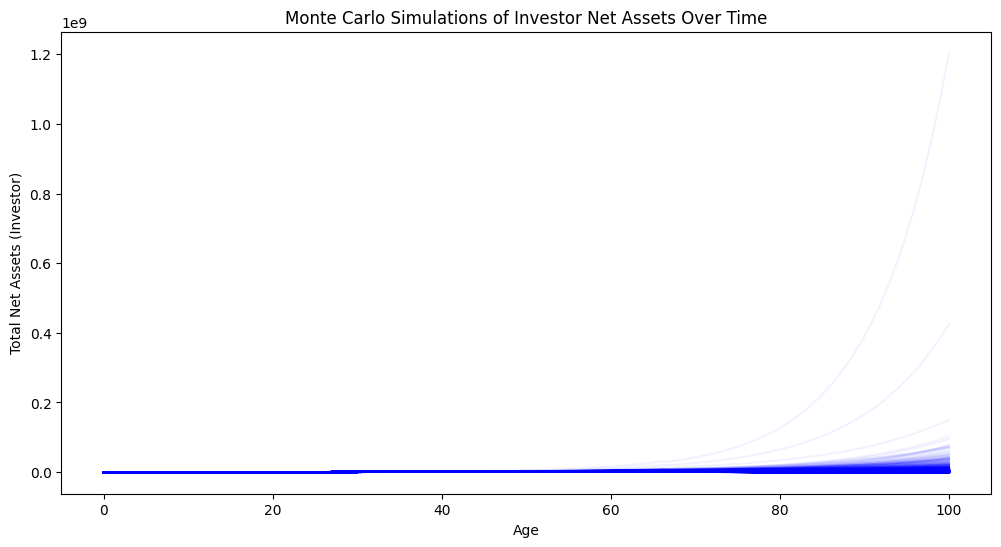

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for key, df in dfs.items():
    plt.plot(df['time'], df['total net asssets (investor)'], color='blue', alpha=0.05)  # alpha sets the transparency


plt.title('Monte Carlo Simulations of Investor Net Assets Over Time')
# plt.yscale('log')
plt.xlabel('Age')
plt.ylabel('Total Net Assets (Investor)');